In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input,
                                     Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

In [ ]:
# auxiliary function to generate a sample quadratic
def simple_quad_1(a):
  return 7*(a**2) - 2*a + 24

def simple_quad(a):
  return (a**2) - 0.3

In [ ]:
import random

def generate_real_samples(num_points):
  first_coordinate = np.random.randn(num_points)
  # first_coordinate = [random.randrange(-2, 2, 1) for i in range(num_points)]

  x_real = np.array([[first_coordinate[i], simple_quad(first_coordinate[i])] for i in range(len(first_coordinate))])
  y_labels = np.array([[1] for i in range(len(x_real))])

  return x_real, y_labels

# generates noise vectors of latent_dim to be fed into generator
def generate_latent_vector_space(latent_dim, num_vectors):
  x_vectors = np.random.randn(latent_dim * num_vectors)
  x_vectors = x_vectors.reshape(num_vectors, latent_dim)

  return x_vectors

def generate_fake_samples(generator, latent_dim, num_points):
	# generates latent space of x values
	x_input = generate_latent_vector_space(latent_dim, num_points)
	# use generator network to get outputs for fake data (predict the y values)
	x_fake = generator.predict(x_input)

  #check this
	y_labels = np.array([[1] for i in range(len(x_input))])

	return x_fake, y_labels

In [ ]:
LATENT_DIM = 2
NUM_POINTS = 10000
EPOCHS = 10000
g_hidden_dim = [4, 3]
d_hidden_dim = [4, 3, 2]

In [ ]:
def generator_model(g_hidden_dim, latent_dim):
  model = Sequential()
  model.add(Dense(g_hidden_dim[0], use_bias=False, activation=LeakyReLU(alpha=0.2), input_dim=latent_dim))
  model.add(BatchNormalization())
  model.add(Dense(g_hidden_dim[1], activation=LeakyReLU(alpha=0.2)))
  model.add(BatchNormalization())
  model.add(Dense(2, activation='linear'))
  assert model.output_shape == (None , 2)
  return model


def discriminator_model(d_hidden_dim):
  model = Sequential()
  model.add(Dense(d_hidden_dim[0], activation='relu', input_dim=2))
  model.add(Dense(d_hidden_dim[1], activation='relu'))
  model.add(Dense(d_hidden_dim[2], activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return model

In [ ]:
generator = generator_model(g_hidden_dim, LATENT_DIM)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 8         
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
 batch_normalization_1 (Batc  (None, 3)                12        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
Total params: 59
Trainable params: 45
Non-trainable para

In [ ]:
discriminator = discriminator_model(d_hidden_dim)

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 3)                 15        
                                                                 
 dense_5 (Dense)             (None, 2)                 8         
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_discriminator(model, num_epochs=1000, batch_size=128):
  half_batch = batch_size // 2

  for i in range(num_epochs):

    # train on real batch

    x_real, y_real = generate_real_samples(num_points=half_batch)
    x_real = np.array(x_real)
    y_real = np.array(y_real)

    model.train_on_batch(x_real, y_real)

    # train on fake batch

    x_fake, y_fake = generate_fake_samples(generator, latent_dim= LATENT_DIM, num_points=half_batch)
    x_fake = np.array(x_fake)
    y_fake = np.array(y_fake)

    model.train_on_batch(x_fake, y_fake)

    _, accuracy_real = model.evaluate(x_real, y_real, verbose = 0)

    _, accuracy_fake = model.evaluate(x_fake, y_fake, verbose = 0)

    print('iteration {}: real_accuracy: {} , fake_accuracy: {}'.format(i + 1, accuracy_real, accuracy_fake))

In [ ]:
train_discriminator(discriminator)

2/2 [==============================] - 0s 6ms/step
iteration 1: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 4ms/step
iteration 2: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 6ms/step
iteration 3: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 5ms/step
iteration 4: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 5ms/step
iteration 5: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 5ms/step
iteration 6: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 5ms/step
iteration 7: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 5ms/step
iteration 8: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 6ms/step
iteration 9: real_accuracy: 1.0 , fake_accuracy: 1.0
2/2 [==============================] - 0s 6ms/step
iteration 10:

In [ ]:
def GAN(generator_model, discriminator_model):
    discriminator_model.trainable = False

    model = tf.keras.Sequential()

    model.add(generator_model)
    model.add(discriminator_model)

    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

latent_space_dimensions = 5

gan_network = GAN(generator, discriminator)
gan_network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 59        
                                                                 
 sequential_1 (Sequential)   (None, 1)                 38        
                                                                 
Total params: 97
Trainable params: 45
Non-trainable params: 52
_________________________________________________________________


In [ ]:
def evaluate_generator(generator, latent_space_dimensions, discriminator, epoch_number, num_samples=100):
    x_real, y_real = generate_real_samples(num_samples)
    _, accuracy_real_data = discriminator.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_space_dimensions, num_samples)
    _, accuracy_fake_data = discriminator.evaluate(x_fake, y_fake, verbose=0)

    print('[ EPOCH {} REAL_DATA {} FAKE_DATA {} ]'.format(epoch_number, accuracy_real_data, accuracy_fake_data))

    plt.scatter(x_real[:, 0], x_real[:, 1], color='blue')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='limegreen')
    plt.show()

In [ ]:
def train_GAN(generator_model, discriminator_model, gan_model, latent_space_dimensions, num_epochs=10000, batch_size=128, evaluation_buffer=1000):
    half_batch = batch_size // 2

    for i in range(num_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(generator_model, latent_space_dimensions, half_batch)

        discriminator_model.train_on_batch(x_real, y_real)
        discriminator_model.train_on_batch(x_fake, y_fake)

        x_latent_space = generate_latent_vector_space(latent_space_dimensions, batch_size)
        y_labels = np.array([[1] for i in range(batch_size)])

        gan_model.train_on_batch(x_latent_space, y_labels)

        if (i + 1) % evaluation_buffer == 0 or i == 0:
            evaluate_generator(generator_model, latent_space_dimensions, discriminator_model, i)
        if (i + 1) == 10000:
            generator_model.save('./models/generator_model')
            discriminator_model.save('./models/discriminator_model')
            gan_model.save('./models/GAN_model')

4/4 [==============================] - 0s 2ms/step
[ EPOCH 0 REAL_DATA 1.0 FAKE_DATA 1.0 ]


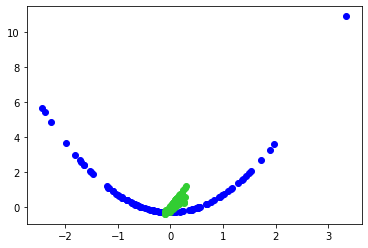

4/4 [==============================] - 0s 3ms/step
[ EPOCH 999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


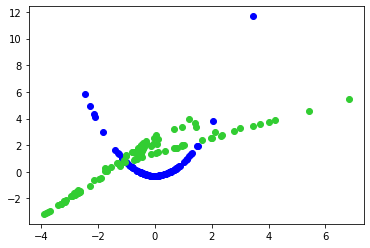

4/4 [==============================] - 0s 5ms/step
[ EPOCH 1999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


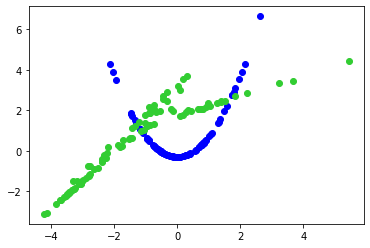

4/4 [==============================] - 0s 4ms/step
[ EPOCH 2999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


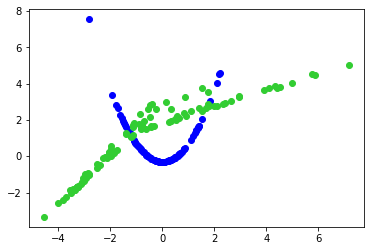

4/4 [==============================] - 0s 5ms/step
[ EPOCH 3999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


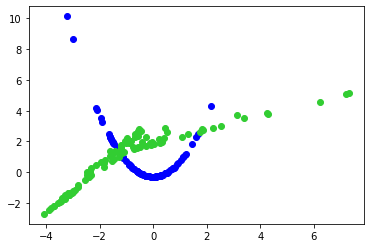

4/4 [==============================] - 0s 5ms/step
[ EPOCH 4999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


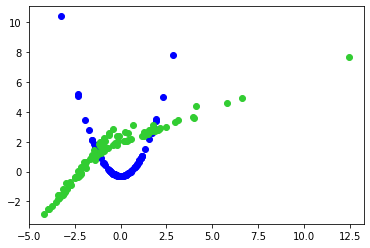

4/4 [==============================] - 0s 5ms/step
[ EPOCH 5999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


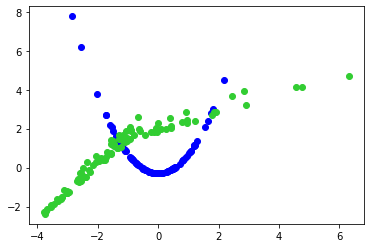

4/4 [==============================] - 0s 3ms/step
[ EPOCH 6999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


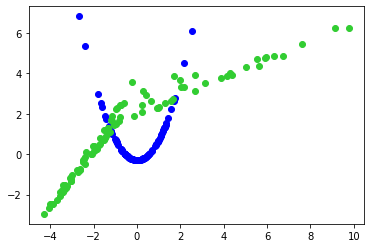

4/4 [==============================] - 0s 5ms/step
[ EPOCH 7999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


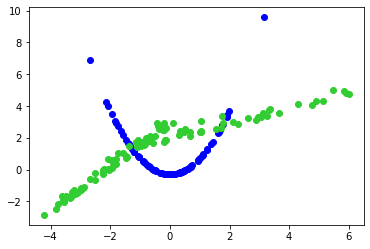

4/4 [==============================] - 0s 5ms/step
[ EPOCH 8999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


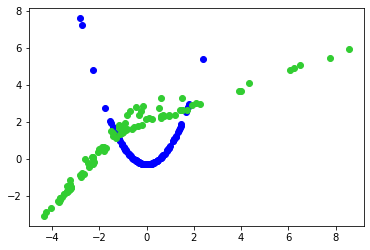

4/4 [==============================] - 0s 5ms/step
[ EPOCH 9999 REAL_DATA 1.0 FAKE_DATA 1.0 ]


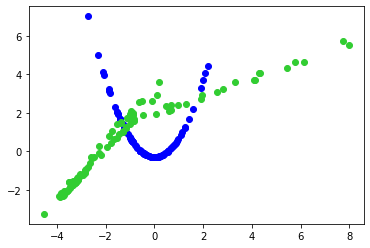

In [ ]:
train_GAN(generator, discriminator, gan_network, LATENT_DIM, 10000)

32/32 [==============================] - 0s 1ms/step
[ EPOCH 10000 REAL_DATA 1.0 FAKE_DATA 1.0 ]


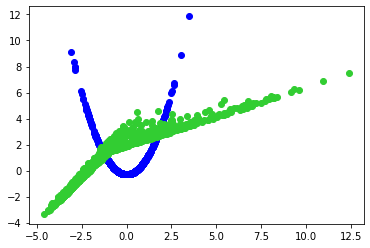

In [ ]:
evaluate_generator(generator, LATENT_DIM, discriminator, epoch_number=10000, num_samples=1000)